In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *
from scipy.signal.windows import dpss
import sys

# Lambda_idx = int(sys.argv[1])
# n_bins = int(sys.argv[2])
# n_chibs = int(sys.argv[3])

Lambda_idx = 18
n_bins = 100
n_chibs = 100

Lambda = Lambdas[Lambda_idx]

# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)


# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)

In [2]:
from scipy.interpolate import interp1d

inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
from scipy.integrate import quad, quad_vec, trapezoid

In [3]:
inner_dkparp_integral.shape

(100, 256, 128)

In [4]:
chibs.shape

(256,)

In [5]:
f_inner_integral = interp1d(x = chibs, y = inner_dkparp_integral, axis = 1)

In [6]:
from tqdm import trange

In [7]:
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2

In [8]:
n_external = n_bins
external_chis =  chi_bin_centers

_chibs = np.linspace(10, chimax_sample, n_chibs)
print('chib spacing', (chimax_sample - 10)/((n_chibs - 1)))

chib spacing 110.69372912693424


In [9]:
#chib spacing isnt super important because delta compensates

In [10]:
interpolated_inner_integral = f_inner_integral(_chibs)

In [11]:
interpolated_inner_integral.shape

(100, 100, 128)

In [12]:
ILoAuto = np.zeros((len(ells), n_external, n_external), dtype=np.float64)

In [13]:
from tqdm import tqdm

In [14]:
deltas

array([1.00000000e-06, 1.11179417e-06, 1.23608629e-06, 1.37427353e-06,
       1.52790931e-06, 1.69872067e-06, 1.88862774e-06, 2.09976532e-06,
       2.33450685e-06, 2.59549111e-06, 2.88565190e-06, 3.20825097e-06,
       3.56691474e-06, 3.96567502e-06, 4.40901439e-06, 4.90191651e-06,
       5.44992222e-06, 6.05919178e-06, 6.73657412e-06, 7.48968386e-06,
       8.32698688e-06, 9.25789550e-06, 1.02928743e-05, 1.14435577e-05,
       1.27228807e-05, 1.41452247e-05, 1.57265784e-05, 1.74847182e-05,
       1.94394079e-05, 2.16126204e-05, 2.40287855e-05, 2.67150637e-05,
       2.97016522e-05, 3.30221239e-05, 3.67138050e-05, 4.08181945e-05,
       4.53814308e-05, 5.04548104e-05, 5.60953643e-05, 6.23664992e-05,
       6.93387105e-05, 7.70903744e-05, 8.57086291e-05, 9.52903545e-05,
       1.05943261e-04, 1.17787100e-04, 1.30955012e-04, 1.45595019e-04,
       1.61871694e-04, 1.79968007e-04, 2.00087382e-04, 2.22455985e-04,
       2.47325268e-04, 2.74974792e-04, 3.05715372e-04, 3.39892570e-04,
      

(1000.0, 1050.0)

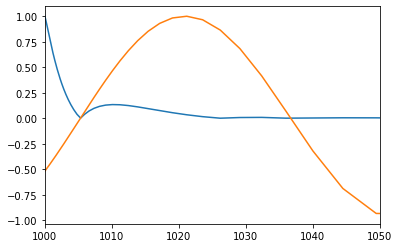

In [16]:
x = 1000 * (1 + deltas)
y = np.sinc(0.1 * x/np.pi)
_tmp = np.abs(y*interpolated_inner_integral[30, 15])
plt.plot(x, _tmp/np.max(_tmp))
plt.plot(x, y/np.max(y))
plt.xlim(1000, 1050)

In [17]:
for chi_idx in trange(n_external):
    chi = external_chis[chi_idx]
    f_KLIMLo1 = get_f_KILo(external_chi = chi, Lambda=Lambda)
    f_KLIMLo1_windowed = apply_window(f_K = f_KLIMLo1,
                                     chimin = chimin,
                                     chimax = chimax)

    f_KLIMLo2 = get_f_KILo(external_chi = external_chis.reshape(n_external,1,1), Lambda=Lambda)
    f_KLIMLo2_windowed = apply_window(f_K = f_KLIMLo2,
                                     chimin = chimin,
                                     chimax = chimax)


    plus = np.einsum('b,d->bd',_chibs, (1+deltas))
    mins = np.einsum('b,d->bd',_chibs, (1-deltas))
#     print(np.diff(plus))
    ret  = f_KLIMLo1_windowed(plus) * f_KLIMLo2_windowed(mins)
    ret += f_KLIMLo1_windowed(mins) * f_KLIMLo2_windowed(plus) 
    factor = (2 / _chibs)

    # so we can integrate dlog delta
    factor = np.einsum('b,d->bd', factor, deltas)
    factor = np.einsum('bd, lbd->lbd', factor, interpolated_inner_integral)

    ret  = np.einsum('pbd,lbd->lpbd', 
                     ret, factor)

    d_delta_integral = trapezoid(x = np.log(deltas), y = ret, axis=-1)
    ILoAuto[:,chi_idx,:] = trapezoid(x = _chibs, y = d_delta_integral, axis=-1)

100%|██████████| 100/100 [08:11<00:00,  4.91s/it]


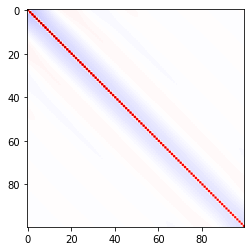

In [18]:
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_idx_%.d_from_quad_nbins_%d.npy'%(zmin, zmax, Lambda_idx, 100)
cov = Pei * np.load(oup_fname)
vb = np.max(np.abs(cov))
plt.imshow(cov, vmin = -vb, vmax = vb, cmap='seismic')

In [19]:
def check_symmetric(a, rtol=1e-03, atol=0.0):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

18.60944187887575


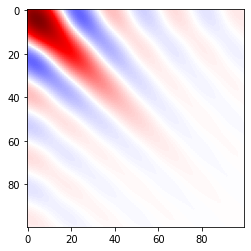

18.527028641374017


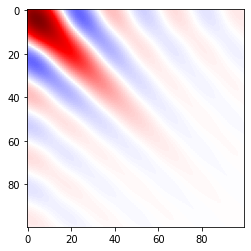

18.43878057147402


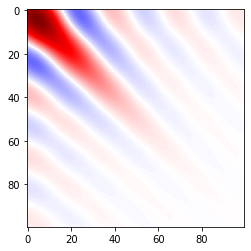

18.344510539308285


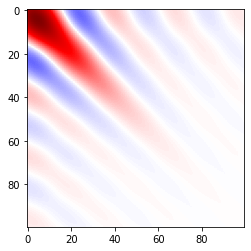

18.244064164070583


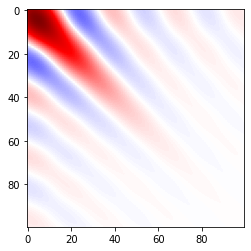

18.137327713513766


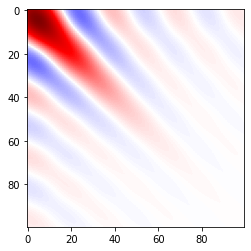

18.02423762222403


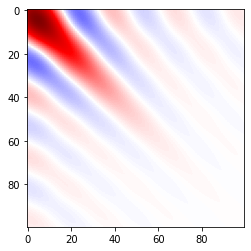

17.90478783500963


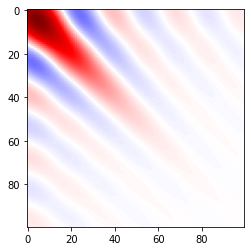

17.77903644879777


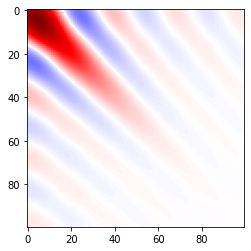

17.64711423220784


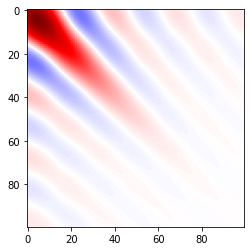

17.49605976780659


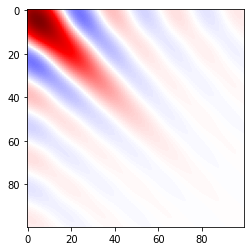

17.337931659156116


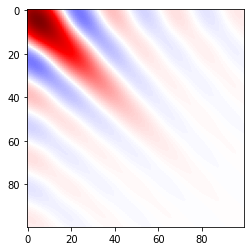

17.174298405004098


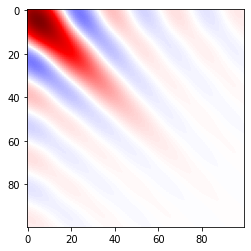

17.005740505713838


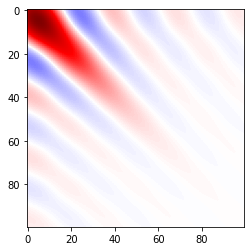

16.83295667966035


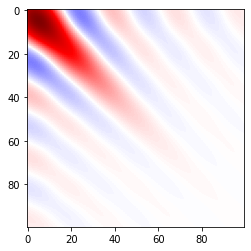

16.6567683608643


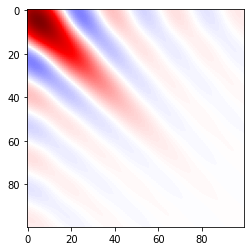

16.478123516508358


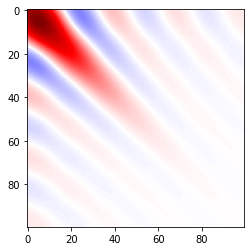

16.29809974606741


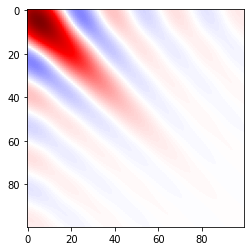

16.11790576187317


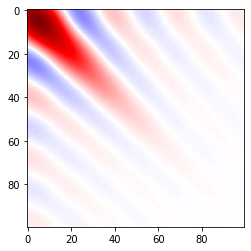

15.938882801948976


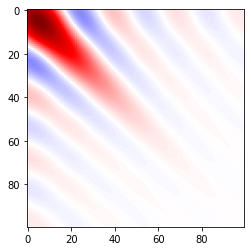

15.762506402797431


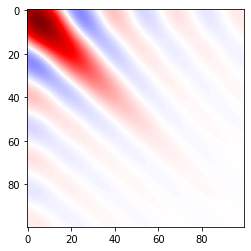

15.590387090713362


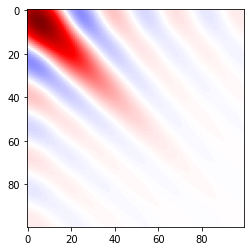

15.424273329703345


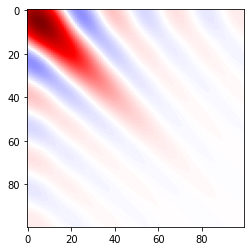

15.266054928844122


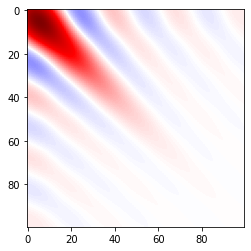

15.117769237336894


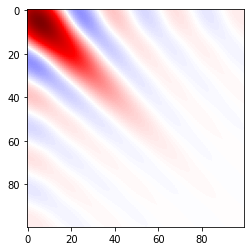

14.981609715000571


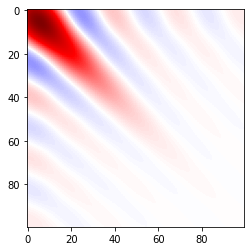

14.848372486698684


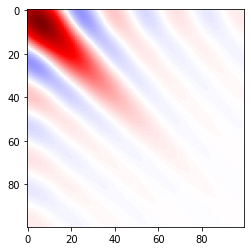

14.731979603743065


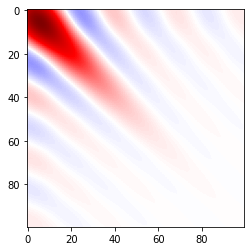

14.63623235959048


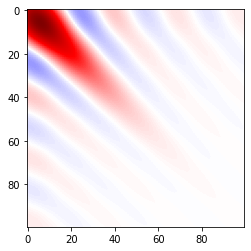

14.56413849380746


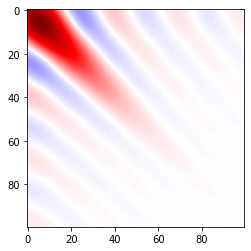

14.518975408498514


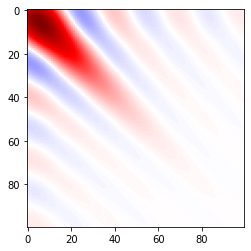

14.50433503844887


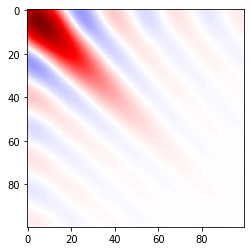

14.524174767605448


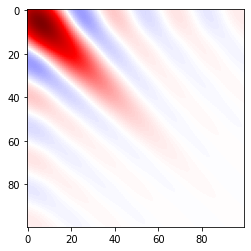

14.582878586386364


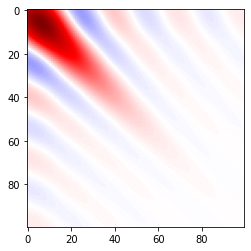

14.685316069347284


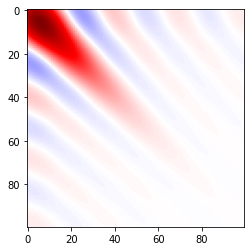

14.836906459644785


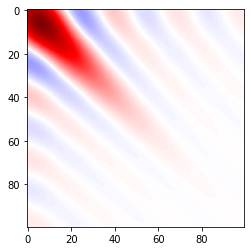

15.043668530818668


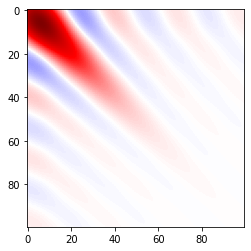

15.31225444719679


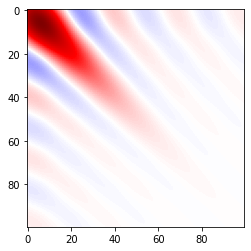

15.649932145473043


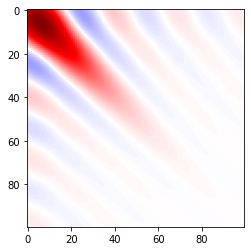

16.06450187981862


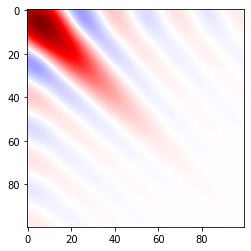

16.56408358119693


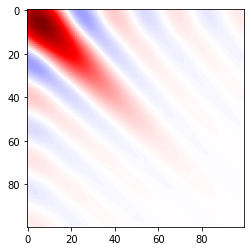

17.156717780747538


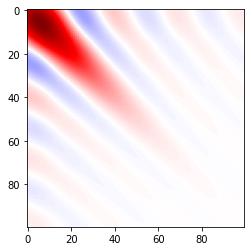

17.849718206539205


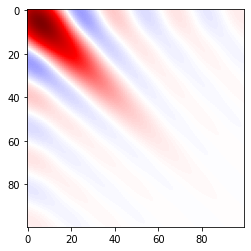

18.64868944703738


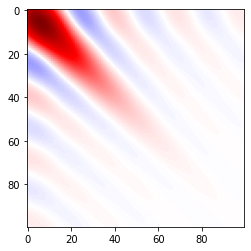

19.556241548119928


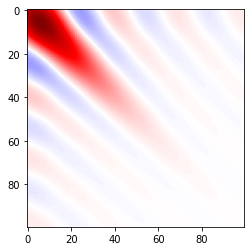

20.570777942639648


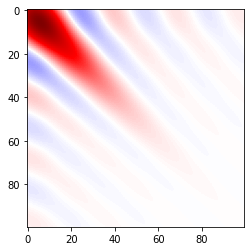

21.689245519621068


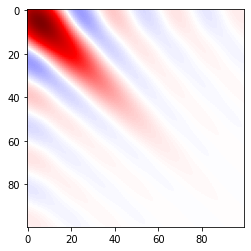

22.88337874899259


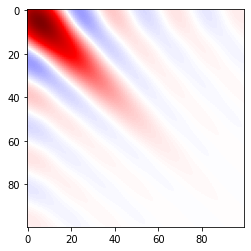

24.11634060092001


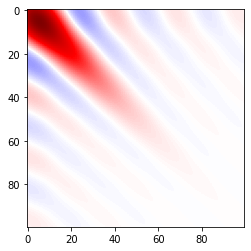

25.367976584933338


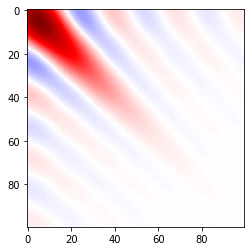

26.613161481928067


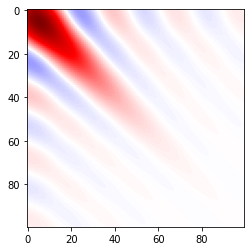

27.84414117064369


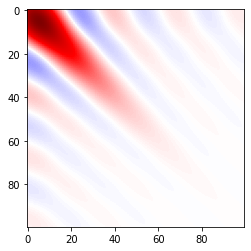

29.07394557210238


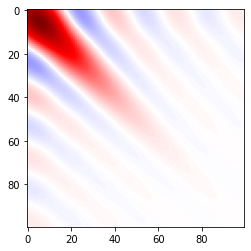

30.31695343417178


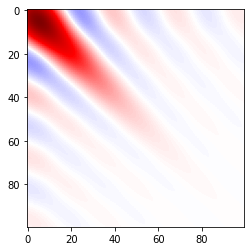

31.61527788612974


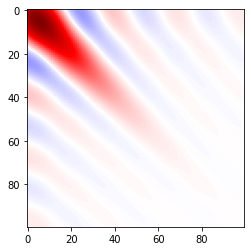

33.163726309650826


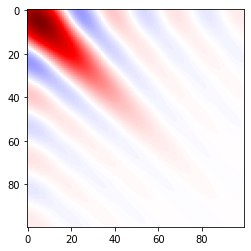

35.097733654247854


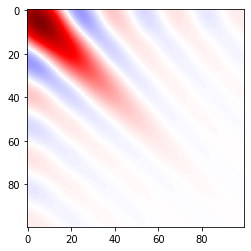

37.620218576803964


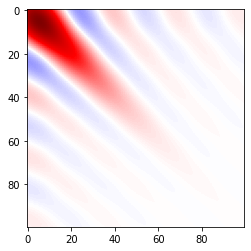

40.92050821419463


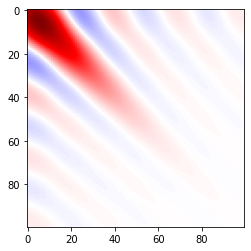

45.12024505933872


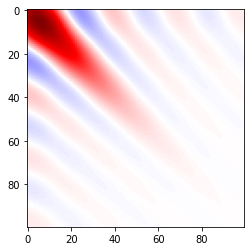

50.202266707895


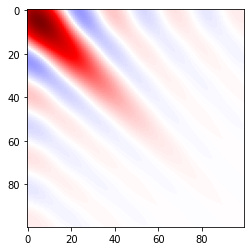

55.90666594979114


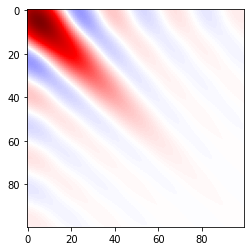

61.66662400886205


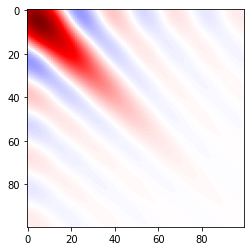

66.85236968062709


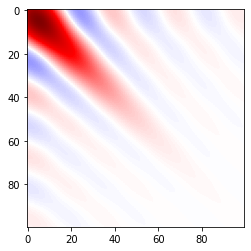

71.31820032206511


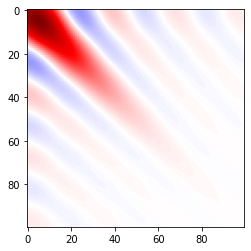

75.73482906949664


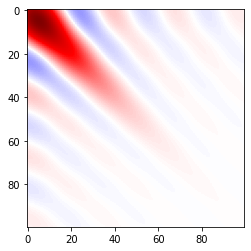

81.56101244919329


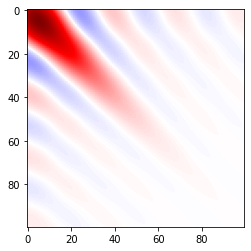

90.4451091840009


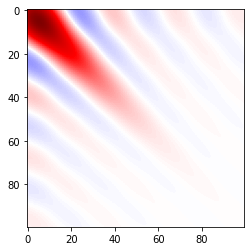

102.92928994280989


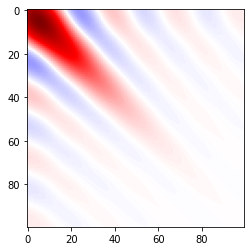

117.6697224544258


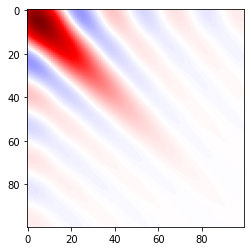

131.4208017556332


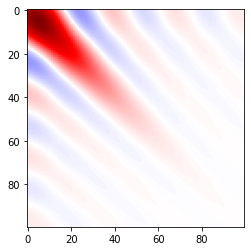

142.39501463669967


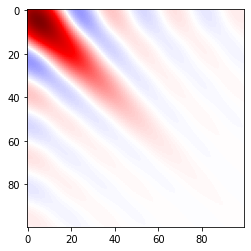

154.13615227342612


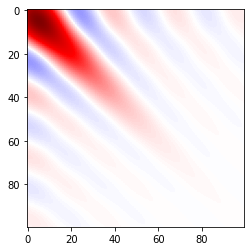

172.25842316941768


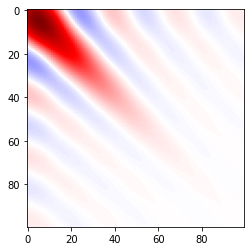

198.27552910267005


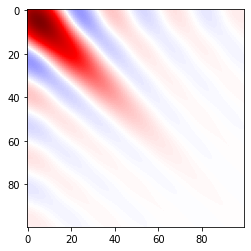

225.53582971098413


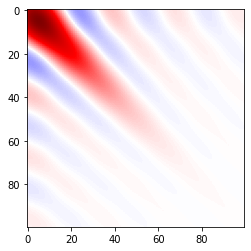

248.4246221509899


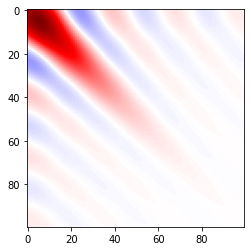

275.087831711662


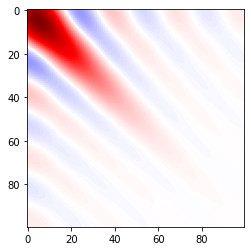

314.5150001749807


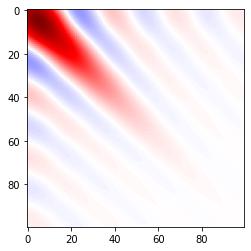

358.85719314628193


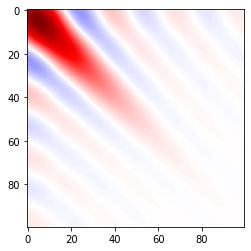

400.366842223122


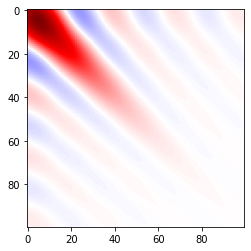

452.6560868424481


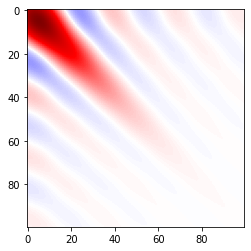

518.1369068790696


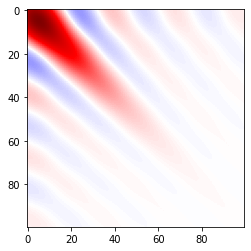

584.9357568668117


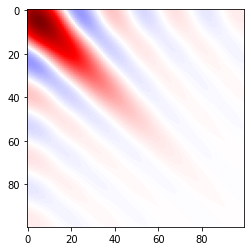

665.1684305731728


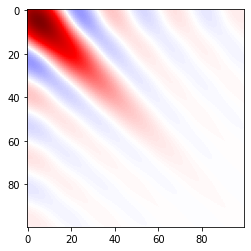

759.6042211766691


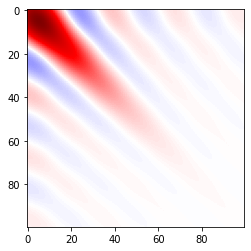

863.5963997221786


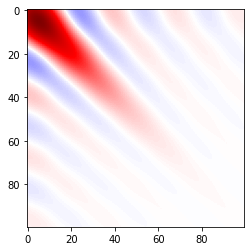

987.8053403675458


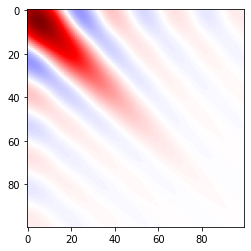

1127.7397036220996


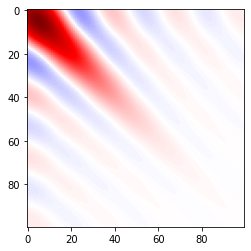

1291.3633593299035


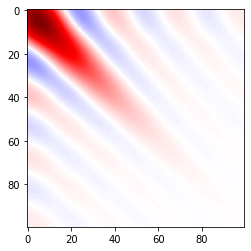

1478.8613474238996


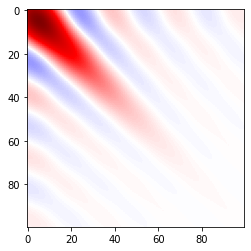

1696.6072777993859


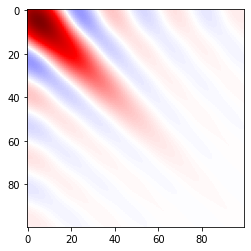

1947.5087623862403


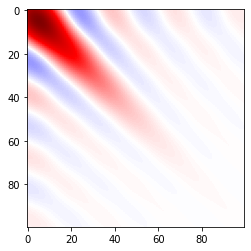

2238.3148813327307


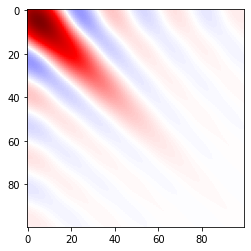

2575.6204252048565


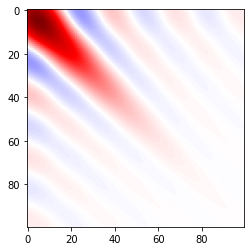

2966.7636686167


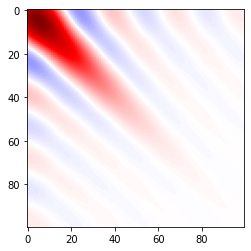

3420.3354671572642


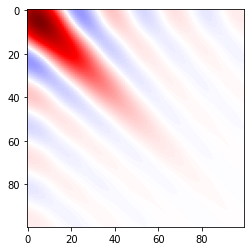

3946.7165784827307


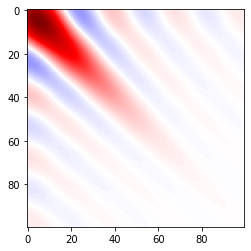

4558.182485059048


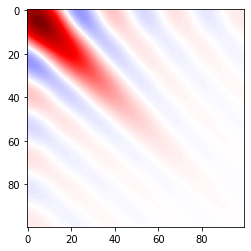

5269.155458780657


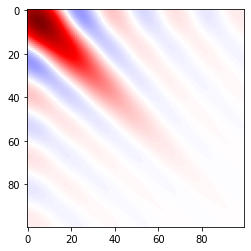

In [20]:
for ell_idx in range(len(ells)):
    tmp_vb = np.max(np.abs(ILoAuto[ell_idx]))
    print(vb/tmp_vb)
    plt.imshow(ILoAuto[ell_idx], vmin = -tmp_vb, vmax = tmp_vb, cmap = 'seismic')
    assert(check_symmetric(ILoAuto[ell_idx]))
    plt.show()